In [46]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Modify this path to the appropriate location in your Drive
data_file = '/content/drive/MyDrive/MIDS/W266/final_project/data/arxiv-metadata-oai-snapshot.json'

In [48]:
!pip install bertopic

# Prepare data

In [49]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [50]:
import json

# https://arxiv.org/help/api/user-manual
category_map = {
'cs.AI': 'Artificial Intelligence',
'cs.CL': 'Computation and Language',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.DL': 'Digital Libraries',
'cs.LG': 'Machine Learning',
'math.ST': 'Statistics Theory',
'physics.comp-ph': 'Computational Physics',
'q-bio.QM': 'Quantitative Methods',
'q-fin.ST': 'Statistical Finance',
'stat.ML': 'Machine Learning'
}

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

titles = []
abstracts = []
years = []
categories = []
metadata = get_metadata()
max_papers = 50000
paper_count = 0
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(ref[-4:])
        # if 2000 < year <= 2023:
        #     categories.append(category_map[paper_dict.get('categories').split(" ")[0]])
        #     years.append(year)
        #     titles.append(paper_dict.get('title'))
        #     abstracts.append(paper_dict.get('abstract'))
        categories.append(category_map[paper_dict.get('categories').split(" ")[0]])
        years.append(year)
        titles.append(paper_dict.get('title'))
        abstracts.append(paper_dict.get('abstract'))
        paper_count += 1
        if paper_count >= max_papers:
            break #stop processing when max_papers is reached.
    except:
        pass

len(titles), len(abstracts), len(years), len(categories)

(22699, 22699, 22699, 22699)

# Train topic model

In [51]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=10)
topics, _ = topic_model.fit_transform(abstracts); len(topic_model.get_topic_info())

2025-03-09 01:01:46,370 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/710 [00:00<?, ?it/s]

2025-03-09 01:02:14,886 - BERTopic - Embedding - Completed ✓
2025-03-09 01:02:14,887 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-09 01:02:20,662 - BERTopic - Dimensionality - Completed ✓
2025-03-09 01:02:20,663 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-09 01:02:22,974 - BERTopic - Cluster - Completed ✓
2025-03-09 01:02:22,982 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-09 01:02:25,617 - BERTopic - Representation - Completed ✓


256

In [52]:
print(f"Length of topics array: {len(topics)}")
print(f"Length of abstracts array: {len(abstracts)}")

Length of topics array: 22699
Length of abstracts array: 22699


In [53]:
print(f"Length of topics array: {len(topics)}")

Length of topics array: 22699


# Topic representation

In [54]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11068,-1_the_of_to_and,"[the, of, to, and, in, we, is, for, that, on]",[ While convolutional neural networks have br...
1,0,365,0_citation_research_citations_journal,"[citation, research, citations, journal, journ...",[ This paper presents the results of a system...
2,1,237,1_market_financial_stock_volatility,"[market, financial, stock, volatility, markets...",[ We analyze the price return distributions o...
3,2,208,2_estimator_lasso_estimators_regression,"[estimator, lasso, estimators, regression, ora...",[ In this article we study post-model selecti...
4,3,207,3_adversarial_attacks_attack_perturbations,"[adversarial, attacks, attack, perturbations, ...",[ Deep neural networks have been shown to per...
5,4,192,4_llms_llm_chatgpt_gpt,"[llms, llm, chatgpt, gpt, language, large, mod...",[ With the recent undeniable advancement in r...
6,5,186,5_face_facial_faces_recognition,"[face, facial, faces, recognition, expression,...",[ This paper aims at determining the characte...
7,6,170,6_causal_treatment_effect_observational,"[causal, treatment, effect, observational, cau...",[ We address the problem of inferring the cau...
8,7,169,7_protein_molecular_proteins_molecules,"[protein, molecular, proteins, molecules, sequ...",[ The effective representation of proteins is...
9,8,167,8_video_videos_action_temporal,"[video, videos, action, temporal, recognition,...",[ High accuracy video label prediction (class...


In [57]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

def evaluate_bertopic_quantitative(topics, categories):
    """
    Quantitatively evaluate BERTopic using NMI and ARI.
    """
    nmi = normalized_mutual_info_score(categories, topics)
    ari = adjusted_rand_score(categories, topics)

    # Count number of unique topics and categories
    n_topics = len(set(topics))
    n_categories = len(set(categories))
    print(f"Number of unique topics: {n_topics}")
    print(f"Number of unique categories: {n_categories}")

    return {"NMI": nmi, "ARI": ari}

def evaluate_bertopic_qualitative(topic_model, topics, abstracts):
    """
    Qualitatively evaluate BERTopic using C_v and NPMI coherence.
    """
    def simple_preprocess(text):
        if isinstance(text, str):
            tokens = text.lower().split()
            return [token for token in tokens if len(token) > 2]
        return text

    # Create dictionary and corpus
    print("Building dictionary and corpus...")
    tokenized_abstracts = [simple_preprocess(abstract) for abstract in abstracts]
    dictionary = corpora.Dictionary(tokenized_abstracts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_abstracts]

    # Get unique topics (excluding outliers)
    unique_topics = [t for t in set(topics) if t != -1]
    print(f"Analyzing {len(unique_topics)} unique topics (excluding outliers)")

    # Get topic words
    topic_words = []
    skipped_topics = 0
    for topic_id in unique_topics:
      try:
        words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
        topic_words.append(words)
      except Exception as e:
        print(f"Error getting topic words for topic {topic_id}: {e}")
        skipped_topics += 1

    print(f"Successfully extracted words for {len(topic_words)} topics (skipped {skipped_topics})")

    if not topic_words:
        print("No valid topics to analyze. Cannot calculate coherence.")
        return {"C_v Coherence": None, "NPMI Coherence": None}

    coherence_results = {}
    try:
        cv_model = CoherenceModel(topics=topic_words, texts=tokenized_abstracts, dictionary=dictionary, coherence='c_v')
        coherence_results["C_v Coherence"] = cv_model.get_coherence()
    except Exception as e:
        print(f"Error calculating C_v coherence: {e}")
        coherence_results["C_v Coherence"] = None

    try:
        print("Calculating NPMI coherence...")
        npmi_model = CoherenceModel(topics=topic_words, texts=tokenized_abstracts, dictionary=dictionary, coherence='c_npmi')
        coherence_results["NPMI Coherence"] = npmi_model.get_coherence()
    except Exception as e:
        print(f"Error calculating NPMI coherence: {e}")
        coherence_results["NPMI Coherence"] = None

    return coherence_results

# Quantitative Evaluation
quantitative_results = evaluate_bertopic_quantitative(topics, categories)
print("Quantitative Evaluation Results:")
for metric, value in quantitative_results.items():
    print(f"{metric}: {value:.4f}")
print()

# Qualitative Evaluation
qualitative_results = evaluate_bertopic_qualitative(topic_model, topics, abstracts)
print("\nQualitative Evaluation Results:")
for metric, value in qualitative_results.items():
    if value is not None:
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: Not Calculated")

Length of categories: 22699
Length of tpics: 22699
Number of unique topics: 256
Number of unique categories: 9
Quantitative Evaluation Results:
NMI: 0.2460
ARI: 0.0017
Building dictionary and corpus...
Analyzing 255 unique topics (excluding outliers)
Successfully extracted words for 255 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.5486
NPMI Coherence: 0.0184


In [58]:
print(f"Length of topics array: {len(topics)}")
print(f"Length of abstracts array: {len(categories)}")

Length of topics array: 22699
Length of abstracts array: 22699


In [66]:
print("Original categories in mapping:", list(category_map.values()))
print("Categories present in dataset:", sorted(set(categories)))
print("Missing categories:", set(category_map.values()) - set(categories))

Original categories in mapping: ['Artificial Intelligence', 'Computation and Language', 'Computer Vision and Pattern Recognition', 'Digital Libraries', 'Machine Learning', 'Statistics Theory', 'Computational Physics', 'Quantitative Methods', 'Statistical Finance', 'Machine Learning']
Categories present in dataset: ['Artificial Intelligence', 'Computation and Language', 'Computational Physics', 'Computer Vision and Pattern Recognition', 'Digital Libraries', 'Machine Learning', 'Quantitative Methods', 'Statistical Finance', 'Statistics Theory']
Missing categories: set()


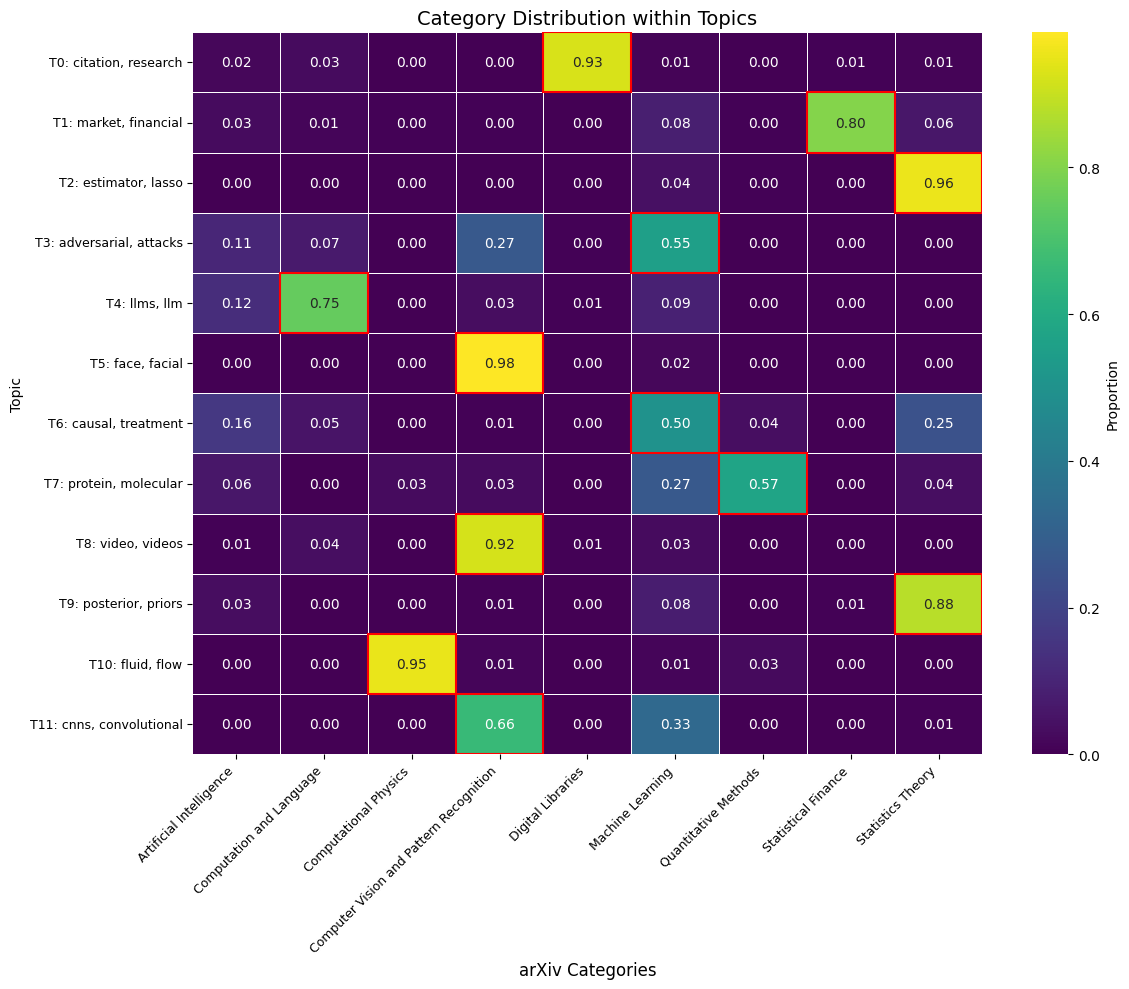

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_readable_topic_category_matrix(topics, categories, topic_model, top_n_topics=12):
    """
    Creates a clear normalized confusion matrix with horizontal y-axis labels
    """
    # Create DataFrame
    df = pd.DataFrame({'Topic': topics, 'Category': categories})

    # Get frequent topics (excluding outliers)
    topic_counts = df['Topic'].value_counts()
    top_topics = topic_counts.drop(-1, errors='ignore').head(top_n_topics).index.tolist()

    # Create compact topic labels
    topic_labels = {}
    for topic in top_topics:
        terms = [term for term, _ in topic_model.get_topic(topic)][:2]  # Only use top 2 terms
        topic_labels[topic] = f"T{topic}: {', '.join(terms)}"

    # Filter data for top topics
    filtered_df = df[df['Topic'].isin(top_topics)]

    # Create normalized matrix
    confusion_matrix = pd.crosstab(filtered_df['Topic'], filtered_df['Category'])
    norm_by_topic = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

    # Set up the figure with extra space on left
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.subplots_adjust(left=0.25)  # Make space for horizontal labels

    # Create heatmap
    sns.heatmap(
        norm_by_topic,
        annot=True,
        cmap="viridis",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Proportion"}
    )

    # Key change: Set y-tick labels to be horizontal
    ax.set_yticks(np.arange(len(top_topics)) + 0.5)
    ax.set_yticklabels(
        [topic_labels[t] for t in norm_by_topic.index],
        fontsize=9,
        rotation=0  # Horizontal text
    )

    # Improve x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=9)

    # Add title and axis labels
    plt.title("Category Distribution within Topics", fontsize=14)
    plt.xlabel("arXiv Categories", fontsize=12)
    # No y-label as we have descriptive topic labels

    # Highlight dominant categories
    for i, topic_idx in enumerate(norm_by_topic.index):
        max_val = norm_by_topic.loc[topic_idx].max()
        max_cat = norm_by_topic.loc[topic_idx].idxmax()
        max_col = norm_by_topic.columns.get_loc(max_cat)
        if max_val > 0.4:  # Highlight if over 40%
            plt.gca().add_patch(plt.Rectangle(
                (max_col, i), 1, 1,
                fill=False, edgecolor='red', lw=1.5
            ))

    return fig, norm_by_topic

# Usage
fig, matrix = create_readable_topic_category_matrix(
    topics, categories, topic_model, top_n_topics=12
)

plt.tight_layout()
plt.show()


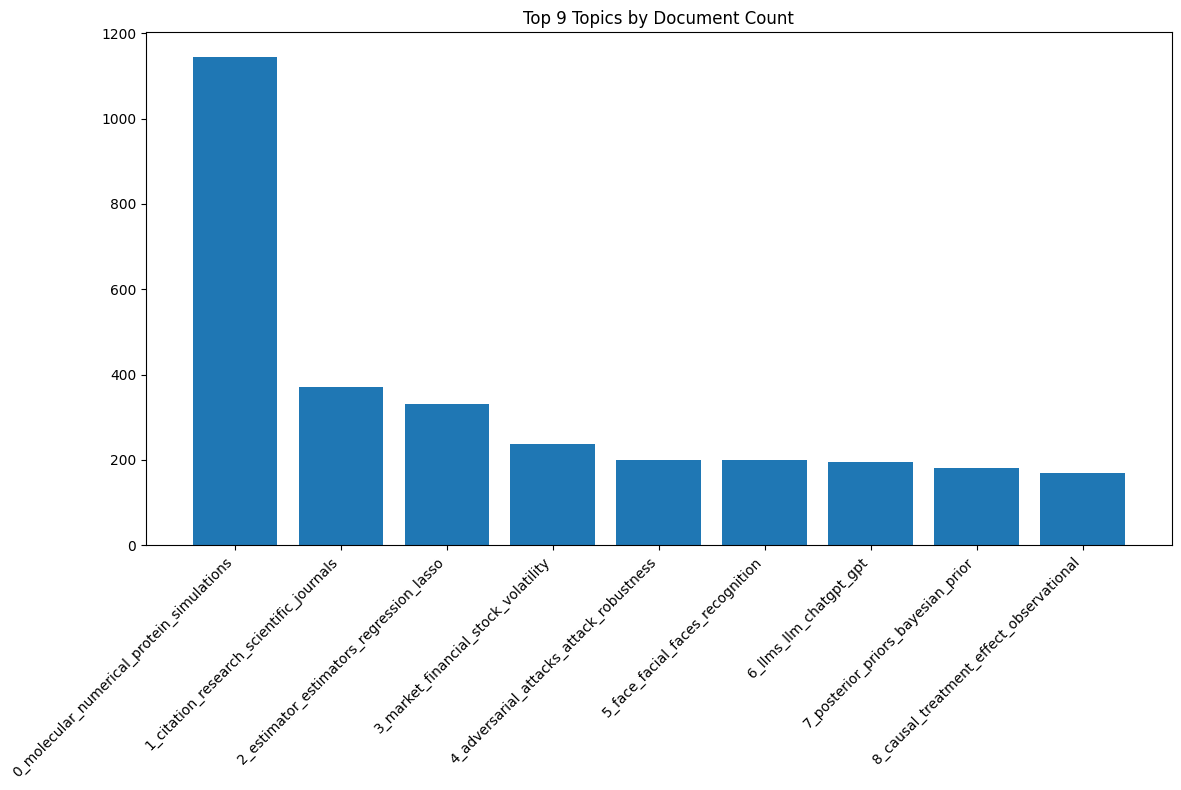

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Get topic info as a DataFrame
topic_df = topic_model.get_topic_info()
topic_df = topic_df[topic_df['Topic'] != -1]  # Remove outlier topic
topic_df = topic_df.head(9)  # Top 9 topics

# Create your own bar chart
plt.figure(figsize=(12, 8))
plt.bar(topic_df['Name'], topic_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 9 Topics by Document Count')
plt.tight_layout()
plt.show()

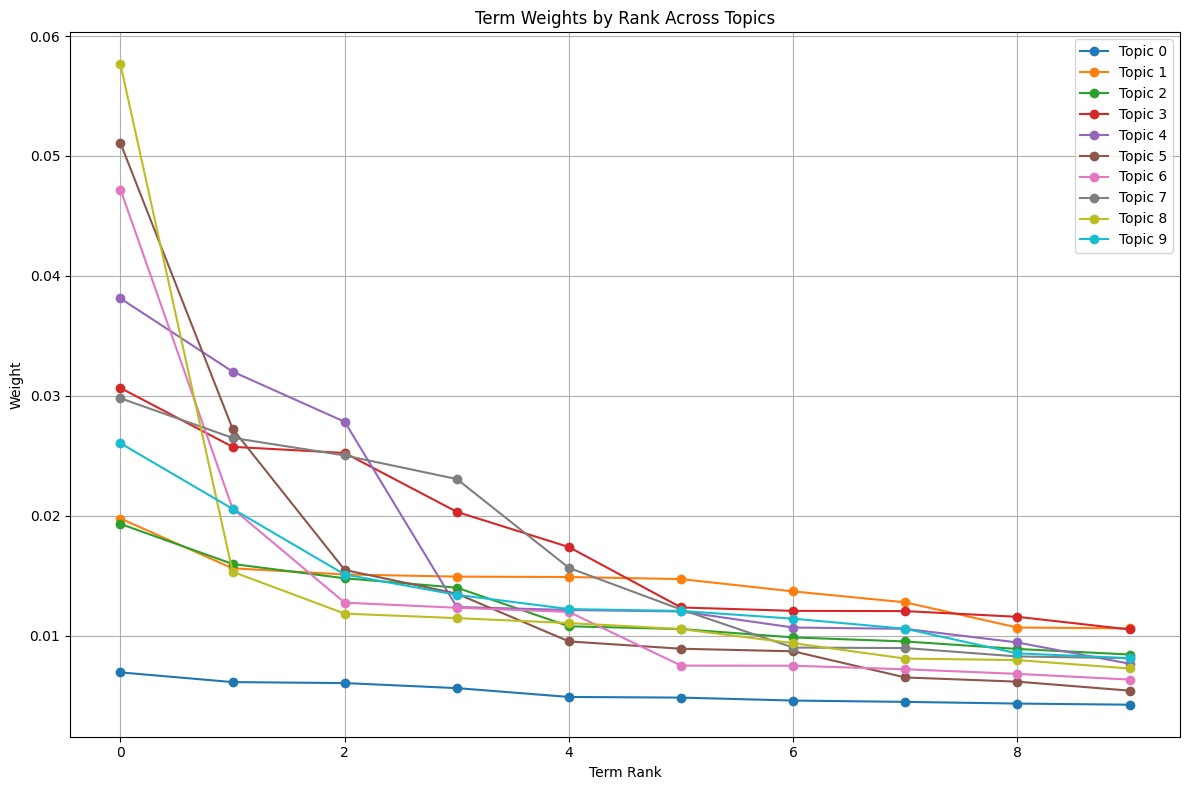

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Get top terms and their frequencies across topics
topic_info = topic_model.get_topic_info()
top_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()[:10]  # Top 10 non-outlier topics

plt.figure(figsize=(12, 8))
for topic in top_topics:
    terms = [term for term, _ in topic_model.get_topic(topic)][:10]  # Top 10 terms
    weights = [weight for _, weight in topic_model.get_topic(topic)][:10]
    plt.plot(range(len(terms)), weights, marker='o', label=f"Topic {topic}")

plt.xlabel("Term Rank")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.title("Term Weights by Rank Across Topics")
plt.tight_layout()
plt.show()

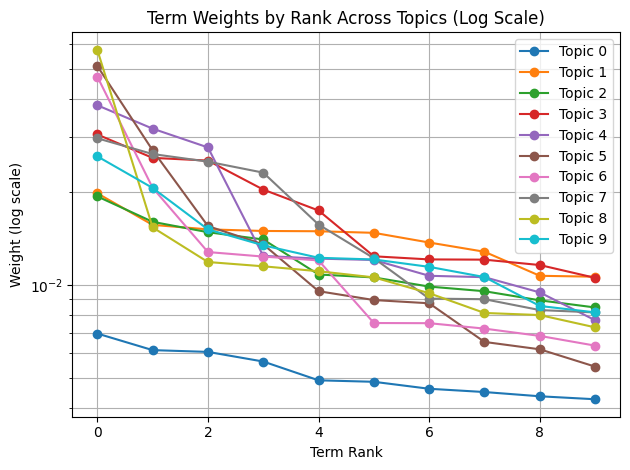

In [38]:
for topic in top_topics:
    terms = [term for term, _ in topic_model.get_topic(topic)][:10]  # Top 10 terms
    weights = [weight for _, weight in topic_model.get_topic(topic)][:10]
    plt.semilogy(range(len(terms)), weights, marker='o', label=f"Topic {topic}")

plt.xlabel("Term Rank")
plt.ylabel("Weight (log scale)")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.title("Term Weights by Rank Across Topics (Log Scale)")
plt.tight_layout()
plt.show()

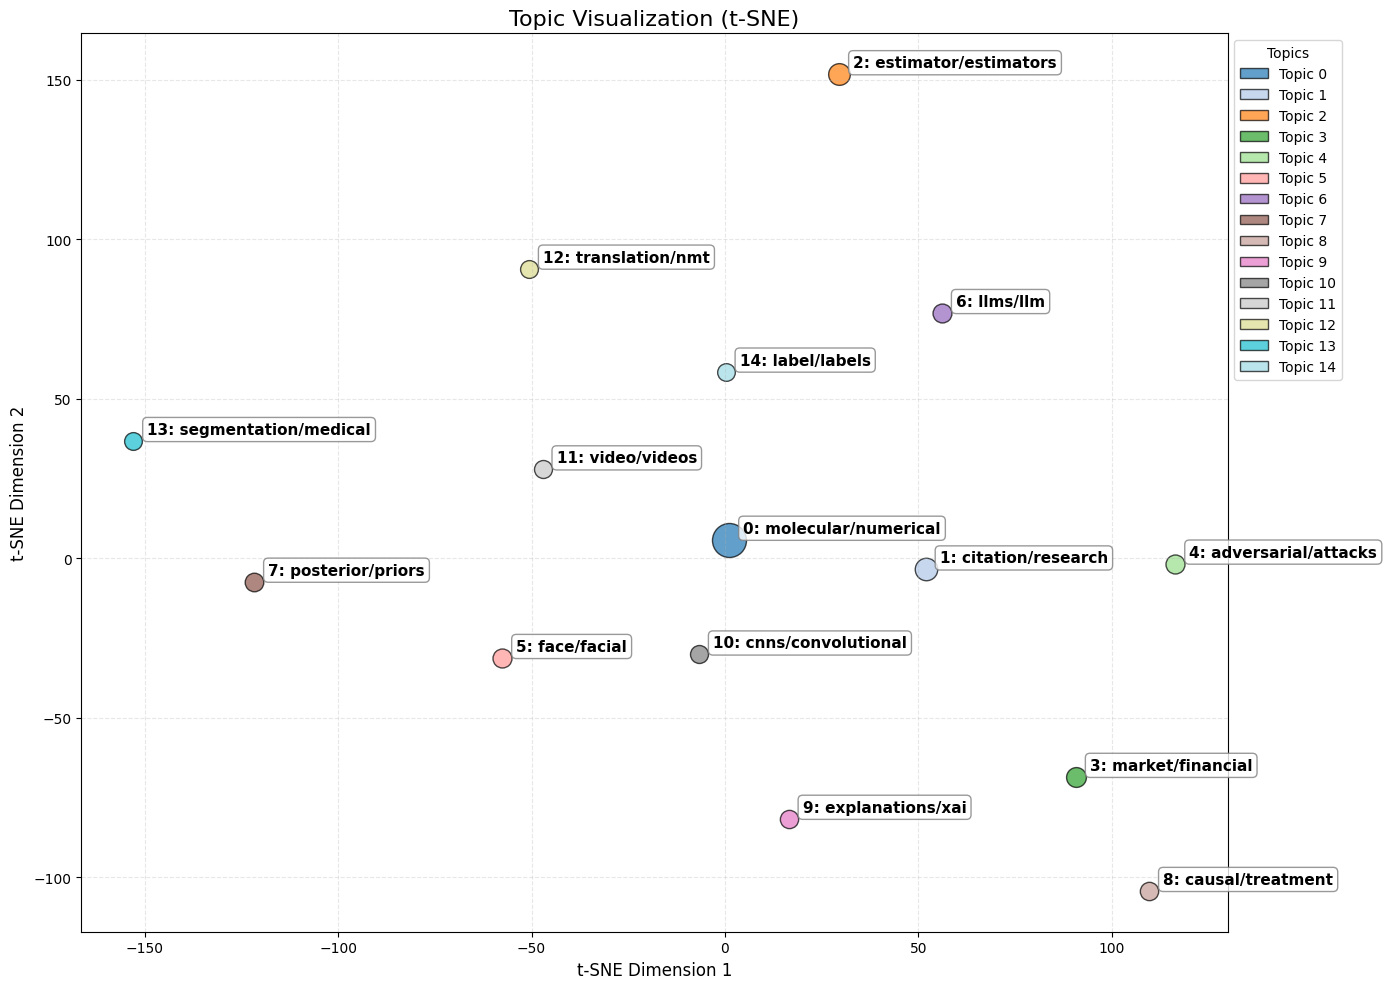

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib.patches import Patch

# Get top 15 topics (excluding outlier topic -1)
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info['Topic'] != -1].head(15)

# Get topic embeddings
embeddings = np.array([topic_model.topic_embeddings_[topic] for topic in topic_info['Topic']])

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

# Get top term for each topic
topic_labels = []
for topic in topic_info['Topic']:
    top_terms = [term for term, _ in topic_model.get_topic(topic)][:2]
    topic_labels.append(f"{int(topic)}: {'/'.join(top_terms)}")

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'topic': topic_info['Topic'],
    'size': topic_info['Count'] / topic_info['Count'].max() * 500 + 100,  # Bigger difference
    'label': topic_labels
})

# Create the plot with a larger figure
plt.figure(figsize=(14, 10))

# Create a custom colormap with distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, len(plot_df)))

# Plot points - use enumeration instead of relying on DataFrame index
for idx, (_, row) in enumerate(plot_df.iterrows()):
    plt.scatter(
        row['x'], row['y'],
        s=row['size'],
        color=colors[idx],  # Use enumeration index instead of DataFrame index
        alpha=0.7,
        edgecolors='black',
        linewidth=1
    )

    # Add text with white outline for visibility
    plt.annotate(
        row['label'],
        (row['x'], row['y']),
        xytext=(10, 5),  # Offset text from point
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

plt.title('Topic Visualization (t-SNE)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Create a legend for topics - also use enumeration for the same reason
legend_elements = []
for idx, (_, row) in enumerate(plot_df.iterrows()):
    legend_elements.append(
        Patch(facecolor=colors[idx], edgecolor='black', alpha=0.7, label=f"Topic {int(row['topic'])}")
    )

# Add legend with the patches
plt.legend(handles=legend_elements, title="Topics", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

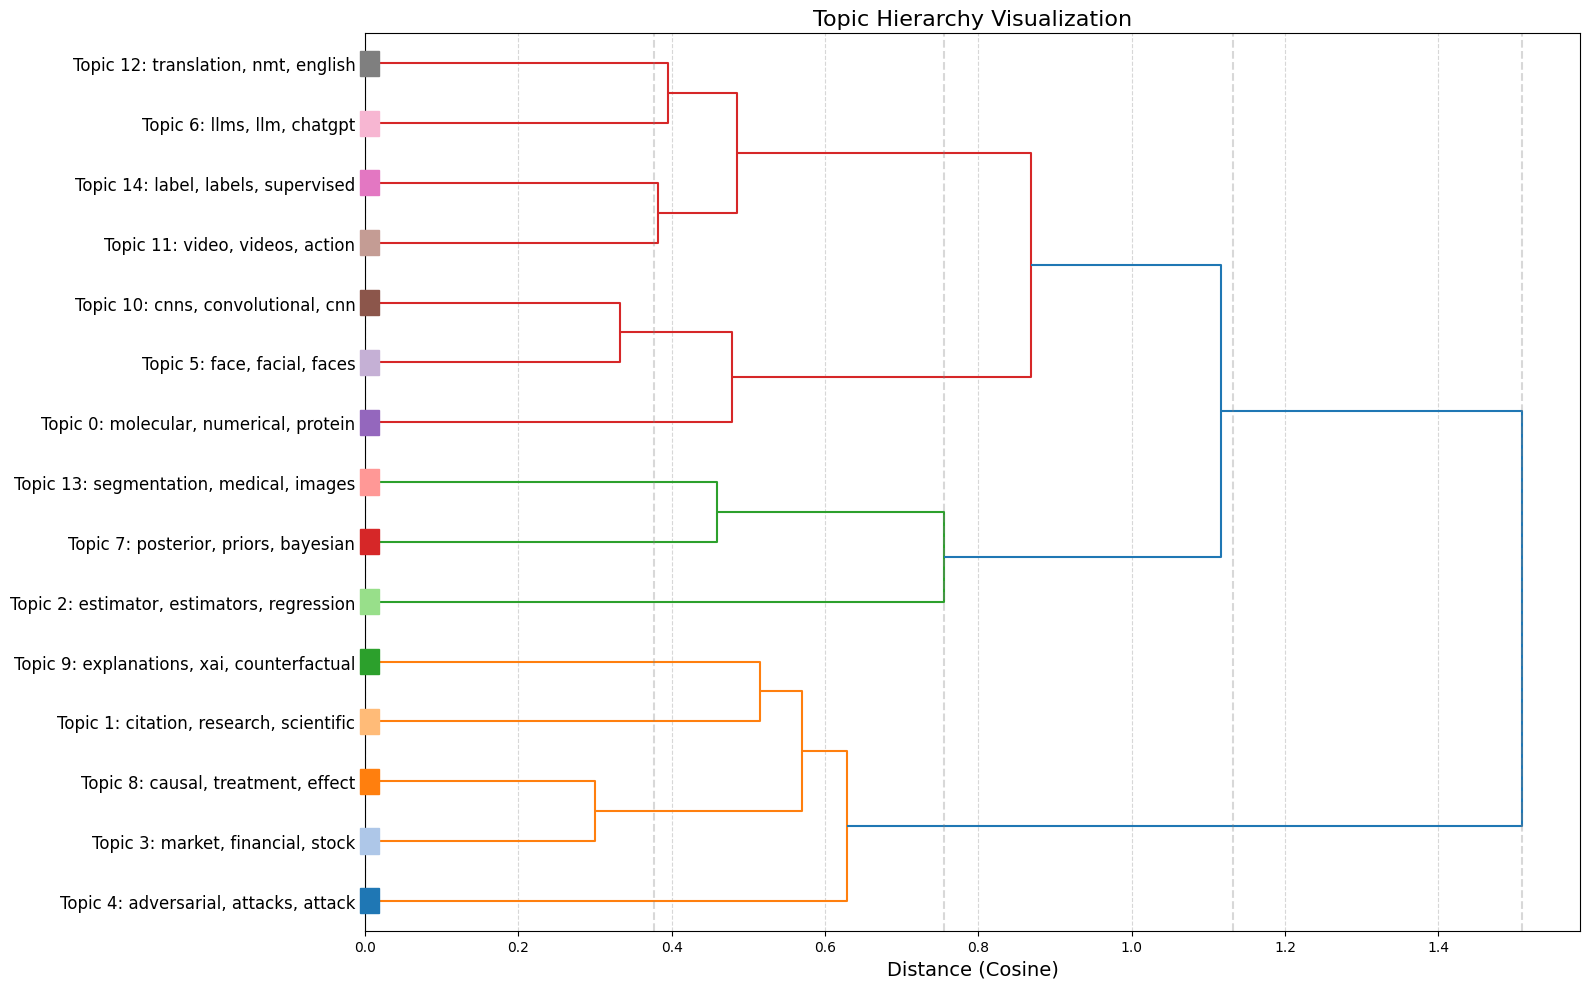

In [41]:
from sklearn.metrics.pairwise import cosine_distances
import scipy.cluster.hierarchy as sch
from matplotlib.colors import rgb2hex

# Get top 15 topics (excluding outlier topic -1)
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info['Topic'] != -1].head(15)
topics = topic_info['Topic'].tolist()

# Get topic embeddings
embeddings = np.array([topic_model.topic_embeddings_[topic] for topic in topics])

# Calculate distance matrix
from sklearn.metrics.pairwise import cosine_distances
distance_matrix = cosine_distances(embeddings)

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Get labels for the topics
labels = []
for topic in topics:
    top_terms = [term for term, _ in topic_model.get_topic(topic)][:3]
    labels.append(f"Topic {topic}: {', '.join(top_terms)}")

# Set figure size
plt.figure(figsize=(16, 10))

# Create dendrogram
dendrogram = sch.dendrogram(
    linkage_matrix,
    orientation='right',
    labels=labels,
    leaf_font_size=12,
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # Color threshold at 70% of max distance
)

# Get colormap
cmap = plt.cm.tab20
colors = [rgb2hex(cmap(i % 20)) for i in range(len(topics))]

# Color the leaf nodes
ax = plt.gca()
for i, label_idx in enumerate(dendrogram['leaves']):
    label_pos = ax.get_yticks()[i]
    ax.text(0, label_pos, '  ', backgroundcolor=colors[i], va='center')

plt.title('Topic Hierarchy Visualization', fontsize=16)
plt.xlabel('Distance (Cosine)', fontsize=14)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add vertical lines to help with distance interpretation
max_x = max(linkage_matrix[:, 2])
for x in np.linspace(0, max_x, 5):
    plt.axvline(x=x, color='gray', linestyle='--', alpha=0.3)

plt.show()

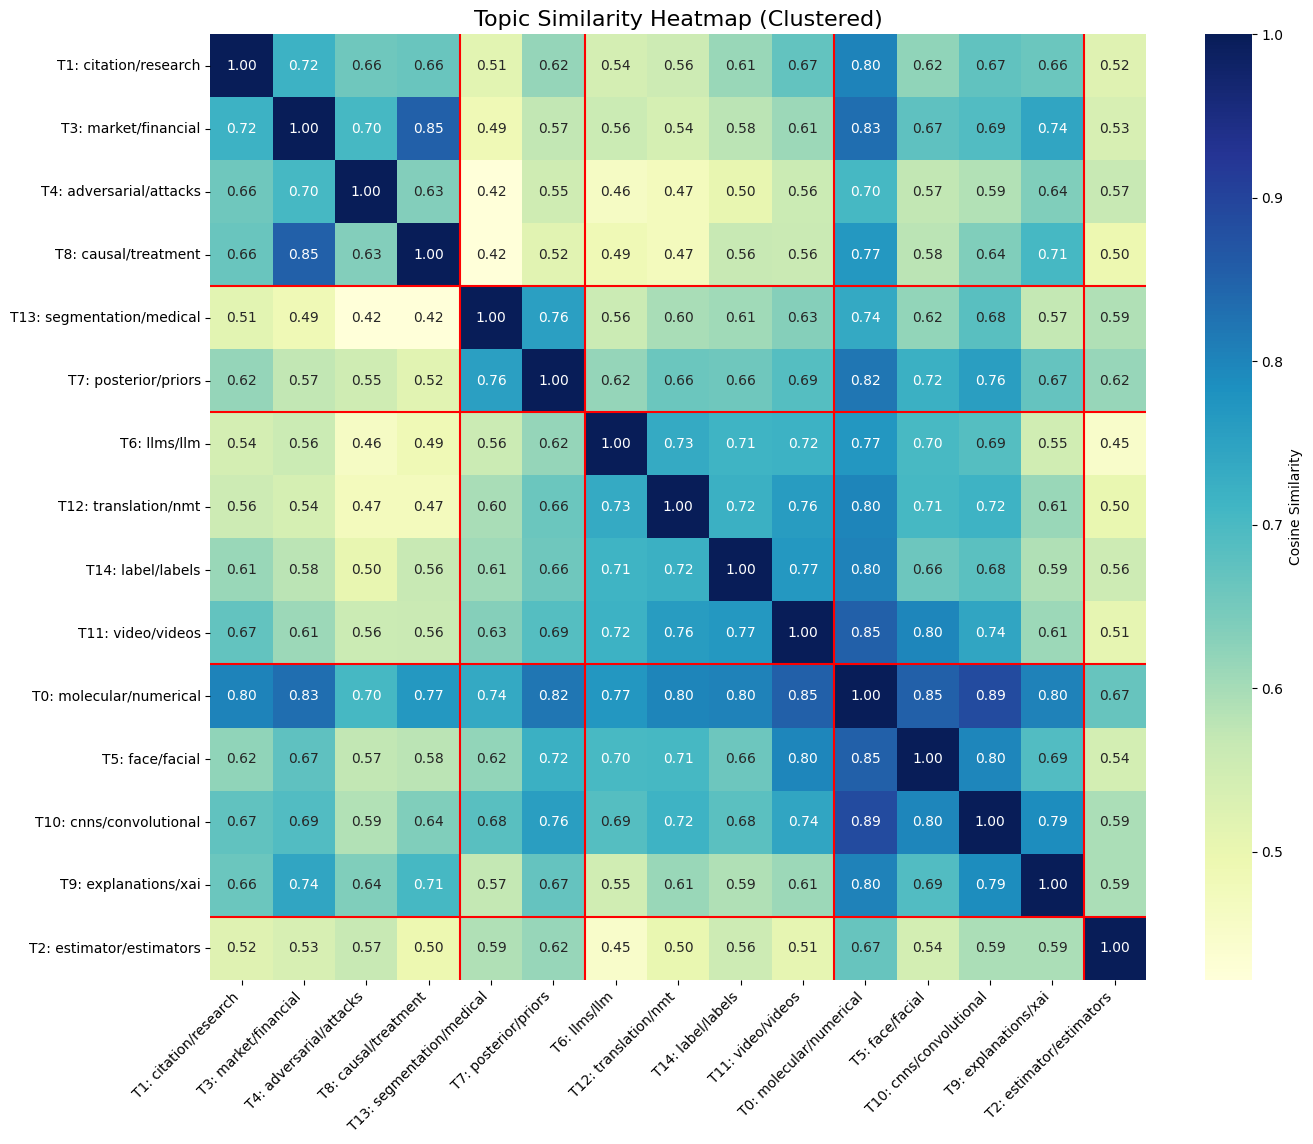

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

# Get top n topics (excluding outlier topic -1)
n_topics = 15
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info['Topic'] != -1].head(n_topics)
topics = topic_info['Topic'].tolist()

# Get topic embeddings
embeddings = np.array([topic_model.topic_embeddings_[topic] for topic in topics])

# Calculate similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Number of clusters
n_clusters = 5

# Perform clustering with minimal parameters
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(embeddings)

# Get labels for topics
labels = []
for topic in topics:
    top_terms = [term for term, _ in topic_model.get_topic(topic)][:2]
    labels.append(f"T{topic}: {'/'.join(top_terms)}")

# Reorder matrix by cluster
ordered_indices = np.argsort(clustering.labels_)
ordered_similarity = similarity_matrix[ordered_indices, :][:, ordered_indices]
ordered_labels = [labels[i] for i in ordered_indices]

# Create a figure
plt.figure(figsize=(14, 12))

# Create heatmap
sns.heatmap(
    ordered_similarity,
    annot=True,
    cmap="YlGnBu",
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cbar_kws={"label": "Cosine Similarity"},
    fmt=".2f"
)

# Create cluster boundaries
cluster_sizes = np.bincount(np.sort(clustering.labels_))
boundaries = np.cumsum(cluster_sizes)[:-1]

# Add horizontal and vertical lines to separate clusters
for boundary in boundaries:
    plt.axhline(y=boundary, color='red', linestyle='-', linewidth=1.5)
    plt.axvline(x=boundary, color='red', linestyle='-', linewidth=1.5)

plt.title('Topic Similarity Heatmap (Clustered)', fontsize=16)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()